# Implement name classifier
1. With `GPU`
2. With `data parallel`
3. Use `pad-pack`

In [1]:
import typing
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from utils import *

torch.manual_seed(1249583)

# See the details in `Dataset` section
SEQUENCE_LENGTH = 19
COUNTRY_LENGTH = 18

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [68]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = make_var(data)        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        tmp = output.view(-1, COUNTRY_LENGTH)
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = make_var(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            tmp = output.view(-1, COUNTRY_LENGTH)
            
            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=test_loader.dataset.countries, normalize=True,
                          title='Confusion matrix')


In [157]:
class TwoLayers(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Another stack
        self.rrelu = nn.LeakyReLU()
        self.gru2 = nn.GRU(output_size, output_size, 1)
        self.fc2 = nn.Linear(output_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        lengths = count_non_zero_length(input)
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input).to(self.device)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        
        pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths)
        packed_output, hidden = self.gru(pps_in, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # This line is no need. Because I use `hidden` as an output
        # result, pps_out_size = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc output: {fc_output.size()}")
        
        # Add one more stack
        hidden2 = self._init_hidden2(batch_size)
        result = self.rrelu(fc_output)
        result, hidden_2 = self.gru2(fc_output, hidden2)
        result = self.fc2(hidden_2)
        return result
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(DEVICE)
    
    def _init_hidden2(self, batch_size):
        return torch.zeros(1, batch_size, COUNTRY_LENGTH)

In [163]:
# classifier = RNNClassifier()
# classifier = ModelX(n_layers=2)
classifier = TwoLayers()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")



in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [164]:
names = ['adylov', 'solan', 'hard', 'san']
# classifier = RNNClassifier()
# classifier = ModelX()
classifier = TwoLayers()
inputs = make_var(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 6]), 
batch out: torch.Size([1, 4, 18])


In [121]:
class ModelX(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=128, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        lengths = count_non_zero_length(input)
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input).to(self.device)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        
        pps_in = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths)
        packed_output, hidden = self.gru(pps_in, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # This line is no need. Because I use `hidden` as an output
        # result, pps_out_size = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc aoutput: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(DEVICE)

In [146]:
# classifier = RNNClassifier()
classifier = ModelX()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")


in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [124]:
names = ['adylov', 'solan', 'hard', 'san']
# classifier = RNNClassifier()
classifier = ModelX()
inputs = make_var(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 6]), 
batch out: torch.Size([1, 4, 18])


In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # input_size 256, hidden_size 256.
        # https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html
        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_dim MUST matches with GRU's input_size 
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        
        # Sung Kim run this all at once (over the whole input sequence)
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        
        # input: B x S -- (transpose) --> S x B
        input = input.t()
        
        # Embedding S x B -> S x B x I (embedding size)
        print(f" input size: {input.size()}")
        embedded = self.embedding(input)
        embedded = embedded.clone().detach().to(self.device) # Make new tensor because of `EmbeddingGrad`
        print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        output, hidden = self.gru(embedded, hidden)
        print(f" gru hidden output: {hidden.size()}")
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        print(f" fc output: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach().to(self.device)

# Dataset

In [16]:
class NameDataSet(Dataset):
    def __init__(self, filename='names_train.csv'):
        trainset = pd.read_csv(filename, header=None)
        trainset.columns = ['name', 'country']
        countries = sorted(list(trainset.country.drop_duplicates()))

        self.trainset = trainset
        self.countries = countries
        self.len = len(trainset)        

    def __getitem__(self, index):
        country = self.trainset.iloc[index]['country']
        return self.trainset.iloc[index]['name'], self.countries.index(country)

    def __len__(self):
        return self.len
        

In [17]:
train_dataset = NameDataSet(filename='../lessons/names_train.csv')
test_dataset = NameDataSet(filename='../lessons/names_test.csv')

In [18]:
%%time
train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=2, num_workers=2) # 2 * 9 * 743 
test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset), batch_size=2, num_workers=2) # 4 * 25 * 67


CPU times: user 8.61 s, sys: 10 ms, total: 8.62 s
Wall time: 8.62 s


# 1. TwoLayers

In [160]:
model = TwoLayers().to(DEVICE)

# 2. Criterion & Loss

In [161]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.795012
Train Epoch: 1 [2000/13374 (15%)]	Loss: 2.988508
Train Epoch: 1 [4000/13374 (30%)]	Loss: 2.492788
Train Epoch: 1 [6000/13374 (45%)]	Loss: 2.417980
Train Epoch: 1 [8000/13374 (60%)]	Loss: 2.608569
Train Epoch: 1 [10000/13374 (75%)]	Loss: 2.721196
Train Epoch: 1 [12000/13374 (90%)]	Loss: 1.481157



Test set: Average loss: 1.2966, Accuracy: 1601/6700 (24%)

[[125   3   5   9   0   4  15  37  30  17  35  23  11   8   9  33   7   3]
 [ 21  35   9  13   0   8  25  10  10  33  16 100   6  19   8  32   9  29]
 [ 17   9  39  14   0   9  35  13  23  23  39  22  32  16  27  25   8   9]
 [ 12   3   4 104   0  17  63  23  10  21  20  25  23  13  15  27   5   3]
 [ 21   5  10  25   2  25  45  18  31  20  15  29  16  13   9  67   4   6]
 [ 44   4   4  18   0  49  65  21  37  20  20  27   7   5   5  45   2   7]
 [ 26   3   6  37   0  25 125  19  18  14  17  15  22  12  12  14   2  10]
 [ 18   5   3  11   0  20  24 160  11   9  15  14   2  20   6   8   2   7]
 [ 30   6   7  19   0  18  18  12  88  28  27  21   8   9  10  56   8   2]
 [ 22   7   7   7   0  14  16   6  12 159  42  19   6  11   3  15  11   6]
 [ 21  21   5  14   0  12  26   9  18  30 155  26  12  11  11  14   5   4]
 [  7  22   8   9   0   8  16  14  16  32  12 105  12   6   8  37  11  30]
 [ 22   6  43  17   0   8  17  17  13  1

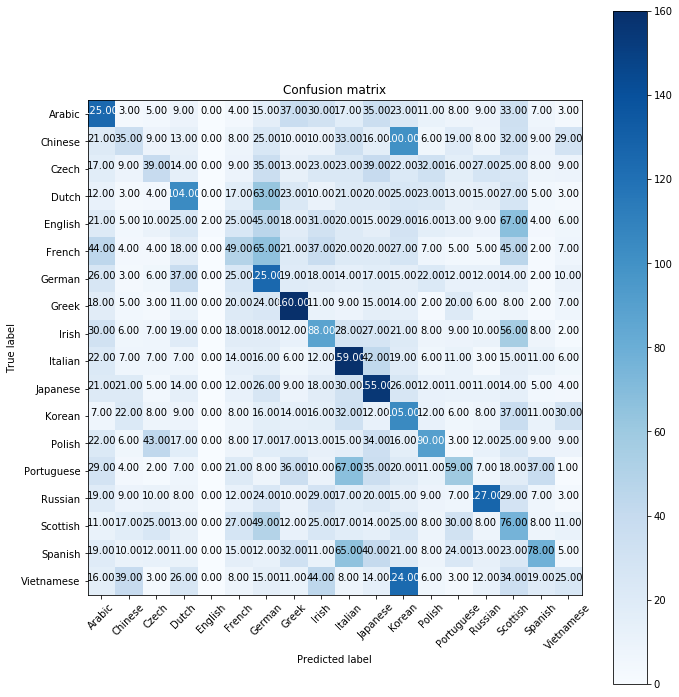

In [162]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

# 1. ModelX

In [125]:
model = ModelX().to(DEVICE)

# 2. Criterion & Loss

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.883689
Train Epoch: 1 [2000/13374 (15%)]	Loss: 2.847184
Train Epoch: 1 [4000/13374 (30%)]	Loss: 3.436334
Train Epoch: 1 [6000/13374 (45%)]	Loss: 0.520430
Train Epoch: 1 [8000/13374 (60%)]	Loss: 3.901955
Train Epoch: 1 [10000/13374 (75%)]	Loss: 1.588154
Train Epoch: 1 [12000/13374 (90%)]	Loss: 3.118987



Test set: Average loss: 1.3303, Accuracy: 1600/6700 (24%)

[[126  18  15   8  13  19   9  27  11  13  30   6   5   6  23   2  23   1]
 [ 16 138  12   8  25  25  12   9  38  19  24  10   3  16  15   2  18  16]
 [ 16  21  82  25  15  25  19  12  14   8  14   8  17   8  31   8  29   3]
 [  8  15  17  96  28  16  32  14   9   7  12  10  21   4  16   7  42  14]
 [ 15  16  14  23  78  39  26  11  21   8  12  15   6  11  11  20  26  12]
 [ 20  11  20  18  29 119   8  21  25   8   6  14   1   9  10  23  28   8]
 [ 17  23  16  40  44  61  66  16  12   2  17   8  18  15  15  13  27  14]
 [ 11  37  12   9  13  27  37 137  10  10  20   5   4  15   7   5  15   0]
 [ 15  17  31  27  27  23  10   6  91   7  20  19   8  17  12  27  14   6]
 [  9  19  18   7  14  18   8  10   9  93  42   8   4  27  11   3  49   6]
 [ 21  17  22  15  16  16   8  14  15   9 118  12   4  13  12   5  29   9]
 [  7  68  18  18  21  24   8  12  26  30  21  69   6  11  10   5  11  16]
 [ 13  35  27  23  28   8   6  17  11   

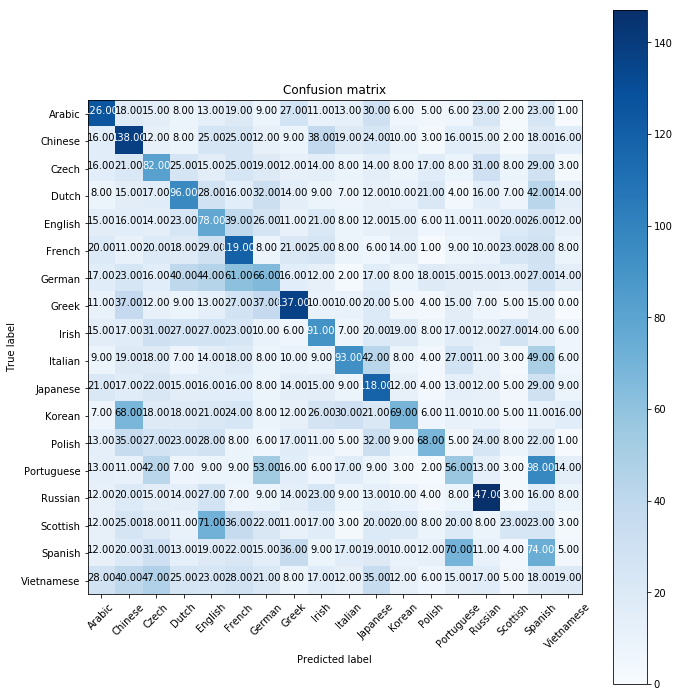

In [127]:
for epoch in tqdm(range(1, 1 + 1)):
    train(model, DEVICE, train_loader, optimizer, epoch, criterion)
    test(model, DEVICE, test_loader, criterion)

# Scratch

In [49]:
aa = ['an', 'catto', 'nicky', 'Tom']
sorted(aa, reverse=True, key=len)

['catto', 'nicky', 'Tom', 'an']